In [3]:
import numpy as np
import matplotlib.pyplot as plt
g=9.81

In [4]:
class X():
    def __init__(self,state=np.zeros(6)):
        self.x,self.y,self.phi=state[0],state[1],state[2]
        self.xDot,self.yDot,self.phiDot=state[3],state[4],state[5]
    def __call__(self):
        return [self.x,self.y,self.phi,self.xDot,self.yDot,self.phiDot]




In [5]:
class Obstacle:
    def __init__(self,x,y,r):
        self.c=np.array([x,y])
        self.r=r
    def CheckCollision(self,state):
        nChecks=state.shape[1]
        for i in range(nChecks):
            currentState=X(state[:,i])
            distance=np.linalg.norm(np.array([currentState.x,currentState.y]-self.c))
            if distance<=self.r:
                return 1
        return 0
    def __call__(self):
        return self.c,self.r

In [ ]:
from scipy.integrate import solve_ivp
goalWidth=20
XLim=800
floor=0
cieling=450


class Quadcopter:
    def __init__(self,m,L,J,state=np.zeros(6),goal=[250,200]):
        self.M=0    #Moment (ie rotation)
        self.L=L
        self.mass=m
        self.torque=J
        self.F=self.mass*g    #Forward Thrust, EQ point
        self.state=X(state)
        self.diffState=None
        self.obstacle=list()
        self.goal=Obstacle(goal[0],goal[1],goalWidth)
    def dynamics(self,inputs,state=None):
        if state is not None:
            self.state=X(state)
        self.F,self.M=inputs
        xDDot=-self.F/self.mass*np.sin(self.state.phi)
        yDDot=self.F/self.mass*np.cos(self.state.phi)-g
        phiDDot=self.M/self.torque
        self.diffState=X([self.state.xDot,self.state.yDot,self.state.phiDot,xDDot,yDDot,phiDDot])
        return self.diffState()
    def solve(self,inputs,nSim=[0,15],nChecks=1000):
        nEval = np.linspace(nSim[0],nSim[1],nChecks)
        solution=solve_ivp(fun=lambda t, state: self.dynamics(inputs,state),
                           t_span=nSim,
                           t_eval=nEval,
                           y0=self.state()
                           )
        self.state= X(solution.y[:, -1])
        if (solution.y[1]<floor).any():
            print("Crashed into the ground")
            #return None
        elif (abs(solution.y[0])>XLim).any():
            print("Crashed into the walls")
        elif (solution.y[0]>cieling):
            print("Crashed into the cieling")
        for obstacle in self.obstacle:
            if obstacle.CheckCollision(solution.y):
                print("Crashed into an obstacle")
                #return None
        if self.goal.CheckCollision(solution.y):
            print("Reached Goal")
        return solution.y
    
    def CreateObstacle(self,x,y,r):
        self.obstacle.append(Obstacle(x,y,r))
    def PlotObjects(self,ax):
        for obstacle in self.obstacle:
            c,r=obstacle()
            circle=plt.Circle((c[0],c[1]),r,color="red",alpha=0.7)
            ax.add_patch(circle)
        c,r=self.goal()   
        circle=plt.Circle((c[0],c[1]),r,color="green",alpha=0.7)
        ax.add_patch(circle)

In [18]:
#Quadcopter and base simulation
m=1; L=1; J=1 #Kg,m,Kgm^2
quad=Quadcopter(m,L,J,goal=[700,350])
quad.CreateObstacle(100,250,100)
quad.CreateObstacle(400,150,50)
quad.CreateObstacle(500,350,50)
quad.CreateObstacle(700,200,75)
sol=quad.solve([4*m*g,-.2],nChecks=1000) #Inputs, and number of checks

Crashed into the walls
Crashed into an obstacle
Crashed into an obstacle
Crashed into an obstacle


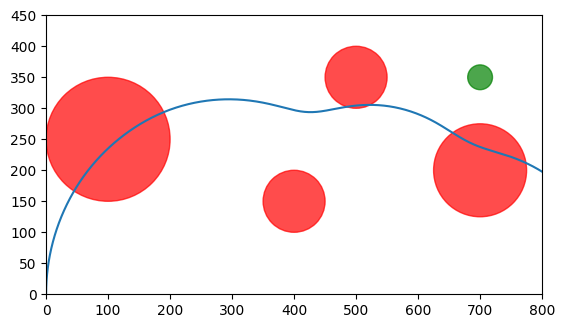

In [ ]:
#Plotting
x,y=sol[0:2]
fig, ax = plt.subplots(1)
ax.plot(x,y)
quad.PlotObjects(ax)
ax.set_aspect('equal',adjustable='box')
ax.set_ylim(floor,cieling)
ax.set_xlim(0,XLim)
plt.show()

2